# Simple Search Engine:
The following code takes a one line query, and find articles which most closley relate to the request by using word frequencies.

In [1]:
## dependencies
import numpy as np 
import pandas as pd 
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
!pip install hdbscan 
from nltk.corpus import stopwords

master = pd.read_csv('/content/drive/My Drive/covid 19 exploration/df/master_text.csv')
master

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Unnamed: 0,paper_id,papepr_title,abstract,main_text,file_path
0,0,0015023cc06b5362d332b3baf348d11567ca2fbb,The RNA pseudoknots in foot-and-mouth disease ...,word count: 194 22 Text word count: 5168 23 2...,"VP3, and VP0 (which is further processed to V...",biorxiv_medrxi
1,1,004f0f8bb66cf446678dc13cf2701feec4f36d76,Healthcare-resource-adjusted vulnerabilities t...,NaN,The 2019-nCoV epidemic has spread across Chin...,biorxiv_medrxi
2,2,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,"Real-time, MinION-based, amplicon sequencing f...",Infectious bronchitis (IB) causes significant...,"Infectious bronchitis (IB), which is caused b...",biorxiv_medrxi
3,3,0139ea4ca580af99b602c6435368e7fdbefacb03,A Combined Evidence Approach to Prioritize Nip...,Nipah Virus (NiV) came into limelight recentl...,Nipah is an infectious negative-sense single-...,biorxiv_medrxi
4,4,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,Assessing spread risk of Wuhan novel coronavir...,Background: A novel coronavirus (2019-nCoV) e...,"In December 2019, a cluster of patients with ...",biorxiv_medrxi
...,...,...,...,...,...,...
29310,29310,ff5a79ed22ea416e6d89caad1cf0d83dbc741a4b,Understanding Human Coronavirus HCoV-NL63,Even though coronavirus infection of humans i...,"Regardless of geographic location, respirator...",noncomm_use_subse
29311,29311,ff6d57f2aad99be129432058665b361dc18747e8,Brief Definitive Report MACROPHAGES GENETICALL...,There is extensive evidence that cultured mac...,Experiments were designed to test whether sub...,noncomm_use_subse
29312,29312,ff83907653a4c4500e8c509ca28169e924742b40,Identification of a Subdomain of CENPB That Is...,We have combined in vivo and in vitro approac...,"can function in an autonomous fashion, reloca...",noncomm_use_subse
29313,29313,ffe718db1820f27bf274e3fc519ab78e450de288,Replication enhancer elements within the open ...,We provide experimental evidence of a replica...,Tick-borne encephalitis virus (TBEV) is a hum...,noncomm_use_subse


# Simple Search Engine
the following code filters the master Dataframe by a give input of words typed in by the user. Additionaly, this code removes and stems user inputed words inorder to probide better matching. The end result is a dataframe which is sorted by the most prevelent articles. 

In [2]:
# master=master[1:100]

key_words = input('Please Type in your Keywords: ')

############# cleaning input #############
stop_words=set(stopwords.words('english'))
key_words = key_words.lower().split(' ')
key_words = [word for word in key_words if word not in stop_words]


#### creating the regex pattern ####
pattern = ""
for word in key_words:
  word = word+"|"
  pattern = pattern + word

###### searching through all texts ######
word_count=[]
drops = []
for i, text in enumerate(master.main_text):
  text = text.lower()
  x=re.findall("{}".format(pattern), text)
  z = 0
  for word in x:
    if word != '': z+=1
  if z > 0:
    word_count.append(z)
    drops.append(True)
  else:
    drops.append(False)

#### visualizing the results #######
df=master[drops]
df['word_counts'] = word_count
df.sort_values('word_counts',ascending=False)


Please Type in your Keywords: Covid


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Unnamed: 0,paper_id,papepr_title,abstract,main_text,file_path,word_counts
45,45,0e38333bff68345492526fd39b70d1b18969cb83,Deep Learning-based Detection for COVID-19 fro...,Accurate and rapid diagnosis of COVID-19 susp...,"huge amount of efforts for radiologists, whic...",biorxiv_medrxi,62
47,47,0eee9760aee0ca2fdf8d1d215c3689d5f8d84df5,Prevalence and clinical features of 2019 novel...,Background With the spread of COVID-19 from W...,The first cluster of cases of pneumonia with ...,biorxiv_medrxi,58
308,308,57a86b3acd182c955877afd4792719a4e9a0ac32,Cross-sectional Study Affiliations,"Background: So far, the psychological impact ...","Since December 2019, coronavirus disease 2019...",biorxiv_medrxi,56
10982,10982,0f15655bda78c3a62a03a19d8028f8f5cf5a1ef5,Clinical characteristics and intrauterine vert...,Background Previous studies on the pneumonia ...,The type of pneumonia caused by the 2019 nove...,custom_licens,56
746,746,de055f09fef2776bc78bac5d58c4131301b2025f,Impacts of Social and Economic Factors on the ...,This paper examines the role of various socio...,Several clusters of patients with pneumonia o...,biorxiv_medrxi,51
...,...,...,...,...,...,...,...
13376,13376,32bc6e6fdbe51b64640357919dc17f29e9b0ebb1,Psychological crisis intervention during the o...,NaN,The outbreak of new coronavirus pneumonia (NC...,custom_licens,1
13565,13565,35be4bfe3809797eb672c5f54b37d3cbd996db74,Highlights Risk factors control in atheroscler...,NaN,"In Taiwan, atherosclerotic cardiovascular dis...",custom_licens,1
13600,13600,364563f6674928b4a6386e656dd217d37e656645,Journal Pre-proof Estimation of the asymptomat...,NaN,This is a PDF file of an article that has und...,custom_licens,1
14316,14316,40dabecefc2f0a2b750e000d1c15cca57a3f7dd4,ANIMAL VIRUSES OF ECONOMIC IMPORTANCE: GENETIC...,NaN,This article is intended as a review of the r...,custom_licens,1


# Clustering after narrowing the Field
The following section is broken into two parts:


1.   Section one: creats a dtm for the filtered data
2.   Sections two: graphs, reduces dimensions , and clusters 




## Section one:


In [4]:
from sklearn.cluster import KMeans
from nltk import wordpunct_tokenize
## DTM Makers ####
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem.porter import PorterStemmer
### Stop Words ####
en_stop = stopwords.words('english')

# Create p_stemmer of class PorterStemmer
port=PorterStemmer
stem_function = PorterStemmer


## stemer function
def stemer(tokens, stem_function):
    stems=[]
    for token in tokens:
        stem=port().stem(token)
        stems.append(stem)
    return stems

## tokenizes words
def tokenizer(text):
    text=re.sub("[^a-z|^\s]", "",  text) # regex to get ride of function
    toks=wordpunct_tokenize(text.lower()) # converting everything to lower case
    new_words= [word for word in toks if word.isalnum()]
    stemed=stemer(toks, stem_function)
    return stemed



word_list = df.main_text.to_list()  
vect = CountVectorizer(tokenizer=tokenizer, stop_words = en_stop, ngram_range= (1,2), max_features = 5000)
vect.fit(word_list)
dtm = vect.transform(word_list)   
df2 = pd.DataFrame(dtm.toarray(), columns=vect.get_feature_names())

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'arent', 'becaus', 'befor', 'couldnt', 'didnt', 'doe', 'doesnt', 'dont', 'dure', 'ha', 'hadnt', 'hasnt', 'havent', 'hi', 'isnt', 'mightnt', 'mustnt', 'neednt', 'onc', 'onli', 'ourselv', 'shant', 'shouldnt', 'shouldv', 'thatll', 'themselv', 'thi', 'veri', 'wa', 'wasnt', 'werent', 'whi', 'wont', 'wouldnt', 'youd', 'youll', 'yourselv', 'youv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


## Section 2: 
The Grpah is Organized as follows
*   Colors = Clusters
*   Words = most common word within an article
*   Axis 1 , Axis 2 = PCA 1, PCA 2
*   Every Point = An article that has been filtered



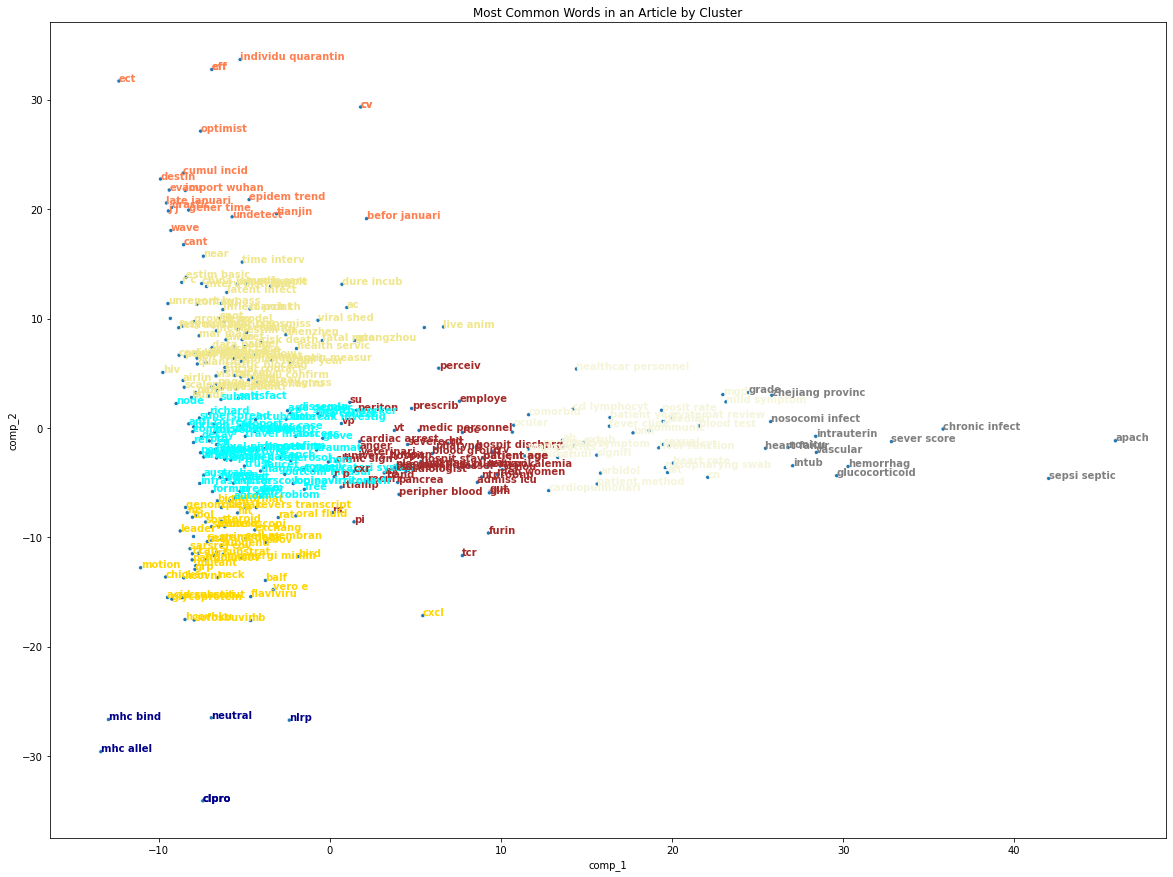

In [29]:
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
import matplotlib._color_data as mcd
import matplotlib.pyplot as plt
import seaborn as sns

#### parameters #####
contamination = .1
n_clusters=8

##### preserving data from previous step
df_t = df
df2_t = df2
master_t = pd.concat([df_t.reset_index(),df2_t.reset_index()], axis=1)
master_t = master_t.dropna()

##### Droping Outliers 
master_t = pd.concat([df_t.reset_index(),df2_t], axis=1)
clf = IsolationForest(n_jobs=-1, contamination=contamination)
master_t['outliers']=clf.fit_predict(master_t.iloc[:,8:])
master_t.iloc[:, 8:] = master_t[master_t.outliers == 1]
master_t = master_t.dropna()

##### Standardizing DF
sc = StandardScaler()
master_t.iloc[:,8:-1] = sc.fit_transform(master_t.iloc[:,8:-1] +.000001)
pca=SparsePCA(n_components=2)
pca_componenets = pca.fit_transform(master_t.iloc[:,8:-1])
pca_componenets = pd.DataFrame(pca_componenets, columns=['comp_1', 'comp_2'])
master_t=pd.concat([master_t.reset_index(),pca_componenets], axis=1)

### Clustering
from sklearn.cluster import KMeans
clf = KMeans(n_clusters=n_clusters,n_jobs=-1)
master_t['clusters'] = clf.fit_predict(master_t.iloc[:,-2:])


### Grpahing 
plt.figure(figsize=(20,15))
p1 = sns.scatterplot(master_t['comp_1'],master_t['comp_2'],data=master_t,size = 10,legend=False)  
p1.set_title("Most Common Words in an Article by Cluster")
colors = [name for name in mcd.CSS4_COLORS if "xkcd:" + name in mcd.XKCD_COLORS]


for title in range(10,master_t.shape[0]):
  most_common=master_t.iloc[title, 9:-5].sort_values().index[-1]
  p1.text(master_t.comp_1[title], master_t.comp_2[title], most_common, horizontalalignment='left', color=colors[master_t.clusters[title] * 3], size =10, weight='semibold')